## Swimmer detector

Inspiration for some code: https://keras.io/examples/vision/object_detection_using_vision_transformer/

Specific example: https://medium.com/nerd-for-tech/building-an-object-detector-in-tensorflow-using-bounding-box-regression-2bc13992973f

Dataset: swimm400 form the paper "Detecting Swimmers in Unconstrained Videos with Few Training Data" by Nicolas Jacquelin, Romain Vuillemot, Stefan Duffner (2021)

In [1]:
import os
import re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
from tensorflow import keras
from tensorflow.keras import layers
from pyMLaux import plot_history # https://github.com/UBod/pyMLaux

In [2]:
# Path to images and annotations
path_images_train = "./swimm400/train/"
path_images_test = "./swimm400/test/"
path_annot = "./swimm400/labels/"
path_models = "./models/"

# gets a list of filepaths of all files in the specified folder
def get_filepaths_for_folder(folder_path):
    return list(f for f in map(lambda f: os.path.join(folder_path, f), os.listdir(folder_path)) if os.path.isfile(f))

# parses an annotation file and extracts 
def read_LabelImg_bbs(path):
    for bndbox in ET.parse(path).getroot().iter("bndbox"):
        yield (
            int(bndbox.find("xmin").text),
            int(bndbox.find("ymin").text),
            int(bndbox.find("xmax").text),
            int(bndbox.find("ymax").text),
        )

# reads and preprocesses images and annotations
def prepare_data(img_paths, image_size=None):
    images = []
    targets = []
    
    for path in img_paths:
        # read image and get size
        image = keras.utils.load_img(path)
        (w, h) = image.size[:2]

        if image_size!=None:
            if isinstance(image_size, int):
                image = image.resize((image_size, image_size))
            else:
                image = image.resize(image_size)

        # convert image to array and append to list
        images.append(keras.utils.img_to_array(image))
        
        # get path to annotation file for image file
        filename = re.search(r"/([^/]+)\.", path).groups()[0]
        annot_path = os.path.join(path_annot, filename + ".xml")
        
        scaled_bbs = []
        
        # read bounding boxes
        bbs = sorted(read_LabelImg_bbs(annot_path), key=lambda b: b[3], reverse=True)
        for (top_left_x, top_left_y, bottom_right_x, bottom_right_y) in bbs:
            # apply relative scaling to bounding boxes as per given image and append to list
            scaled_bbs.append(float(top_left_x) / w)
            scaled_bbs.append(float(top_left_y) / h)
            scaled_bbs.append(float(bottom_right_x) / w)
            scaled_bbs.append(float(bottom_right_y) / h)
        
        targets.append(scaled_bbs)
        
    return (images, targets)

# fills all target arrays to the maximum number of elements to prevent jagged arrays for numpy
def fill_targets(target_lists):
    max_swimmers = 0

    for target_list in target_lists:
        for target in target_list:
            max_swimmers = max(len(target), max_swimmers)

    for target_list in target_lists:
        for target in target_list:
            for _ in range(max_swimmers - len(target)):
                #target.append([0., 0., 0., 0.])
                target.append(0.)

    return max_swimmers // 4

In [3]:
# list of paths to images and annotations
train_image_paths = get_filepaths_for_folder(path_images_train)
test_image_paths = get_filepaths_for_folder(path_images_test)
annot_paths = get_filepaths_for_folder(path_annot)

image_size = 224  # resize input images to this size

In [ ]:
(train_images, train_targets) = prepare_data(train_image_paths, image_size)
(test_images, test_targets) = prepare_data(test_image_paths, image_size)

max_swimmers = fill_targets([train_targets, test_targets])

# Convert the list to numpy array, split to train and test dataset
x_train = np.asarray(train_images)
y_train = np.asarray(train_targets)

x_test = np.asarray(test_images)
y_test = np.asarray(test_targets)

In [5]:
neurons = 32
while neurons <= max_swimmers * 4:
    neurons *= 2

model = tf.keras.models.Sequential([
    #create the base layers
    layers.Input((image_size, image_size, 3)),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.Dropout(0.35),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.Dropout(0.35),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.Dropout(0.35),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.35),
    #create the localiser branch
    layers.Dense(neurons * 4, activation="relu"),
    layers.Dropout(0.35),
    layers.Dense(neurons * 2, activation="relu"),
    layers.Dropout(0.35),
    layers.Dense(neurons, activation="relu"),
    layers.Dropout(0.35),
    layers.Dense(max_swimmers * 4, activation="sigmoid")
])

model.compile(optimizer="adam", loss="MSE", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 dropout (Dropout)           (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 dropout_1 (Dropout)         (None, 112, 112, 32)      0         
                                                        

In [6]:
filepath = path_models + "swimm400_{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=30, batch_size=4, callbacks=[checkpoint], verbose=0)
tf.keras.backend.clear_session()


Epoch 1: val_accuracy improved from -inf to 0.58750, saving model to ./models\swimm400_01-0.5875.hdf5

Epoch 2: val_accuracy did not improve from 0.58750

Epoch 3: val_accuracy did not improve from 0.58750

Epoch 4: val_accuracy did not improve from 0.58750

Epoch 5: val_accuracy did not improve from 0.58750

Epoch 6: val_accuracy improved from 0.58750 to 0.60000, saving model to ./models\swimm400_06-0.6000.hdf5

Epoch 7: val_accuracy improved from 0.60000 to 0.62500, saving model to ./models\swimm400_07-0.6250.hdf5

Epoch 8: val_accuracy did not improve from 0.62500

Epoch 9: val_accuracy improved from 0.62500 to 0.68750, saving model to ./models\swimm400_09-0.6875.hdf5

Epoch 10: val_accuracy did not improve from 0.68750

Epoch 11: val_accuracy did not improve from 0.68750

Epoch 12: val_accuracy did not improve from 0.68750

Epoch 13: val_accuracy did not improve from 0.68750

Epoch 14: val_accuracy did not improve from 0.68750

Epoch 15: val_accuracy did not improve from 0.68750



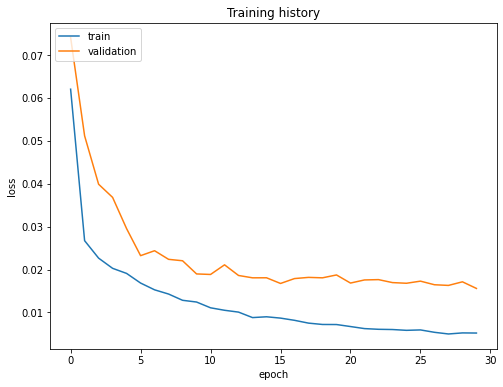

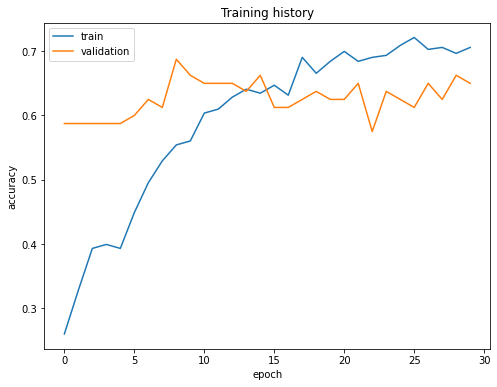

In [7]:
plot_history(history)

In [8]:
# calculate absolute bounding boxes for the given size
def calculate_bbs(coords, w, h):
    boxes = []
    for i in range(0, max_swimmers * 4, 4):
        (top_left_x, top_left_y, bottom_right_x, bottom_right_y) = coords[i:i+4]
        boxes.append([
            int(top_left_x * w),
            int(top_left_y * h),
            int(bottom_right_x * w),
            int(bottom_right_y * h)
        ])
    return boxes

# draw bounding boxes on the given axis
def draw_bbs(boxes, ax):
    for box in boxes:
        (top_left_x, top_left_y, bottom_right_x, bottom_right_y) = box
        rect = patches.Rectangle(
            (top_left_x, top_left_y),
            bottom_right_x - top_left_x,
            bottom_right_y - top_left_y,
            facecolor="none",
            edgecolor="red",
            linewidth=1,
        )
        ax.add_patch(rect)

# draw given images once with prediction and once with annotation
def compare_images(model, images, annotations):
    for image, annotation in zip(images, annotations):
        (fig, (ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 15))

        # display the image
        ax1.imshow(image.astype("uint8"))
        ax2.imshow(image.astype("uint8"))

        # generate prediction
        (w, h) = image.shape[:2]
        preds = model.predict(np.reshape(image, (1, w, h, 3)))[0] # reshape because batch size of 1

        # calculate absolute bounding boxes for prediction
        boxes_predicted = calculate_bbs(preds, w, h)
        draw_bbs(boxes_predicted, ax1)
        
        ax1.set_xlabel("Predicted")

        # calculate absolute bounding boxes for annotations
        boxes_annot = calculate_bbs(annotation, w, h)
        draw_bbs(boxes_annot, ax2)
        
        ax2.set_xlabel("Annotated")

        plt.show()

## First model like in example

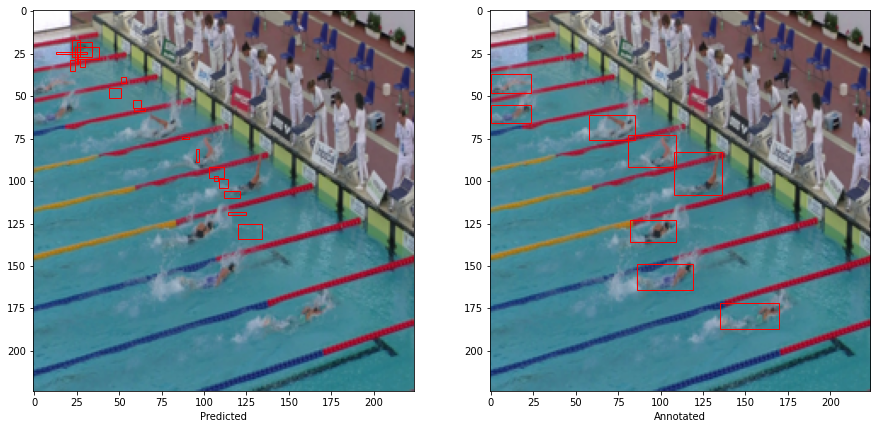

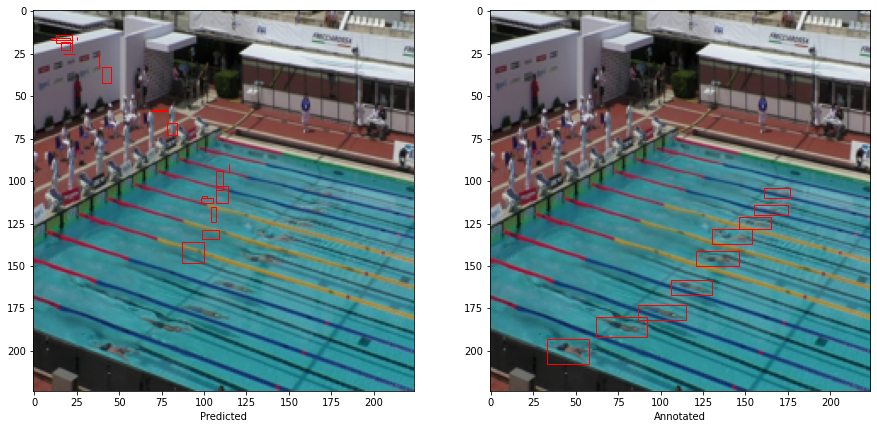

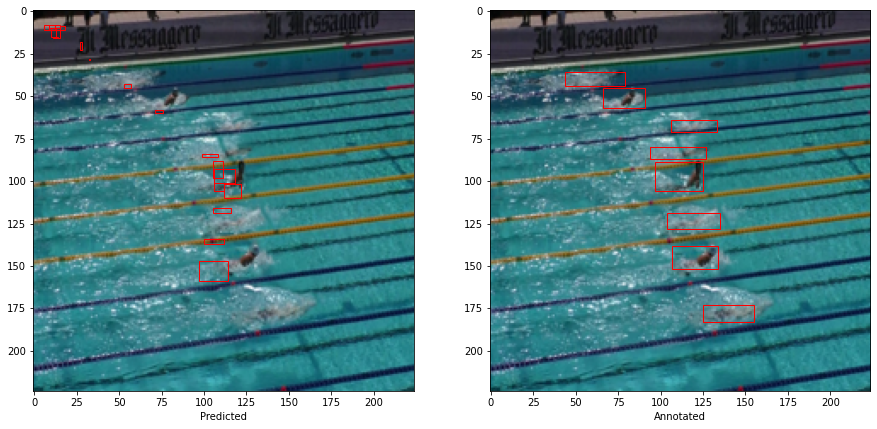

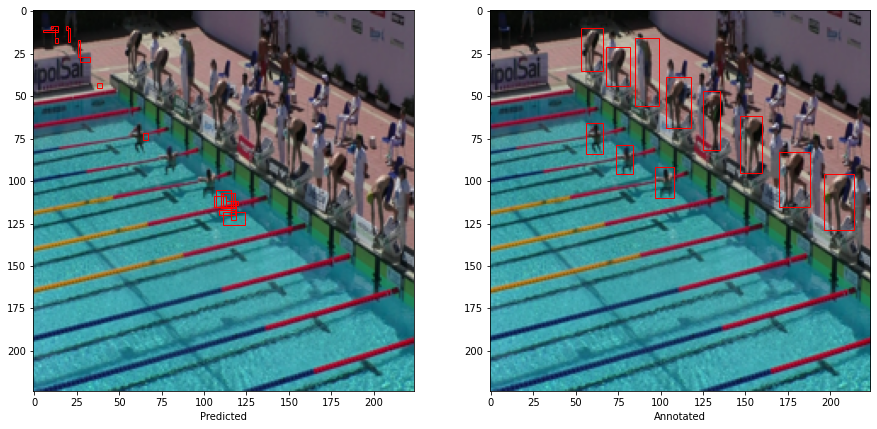

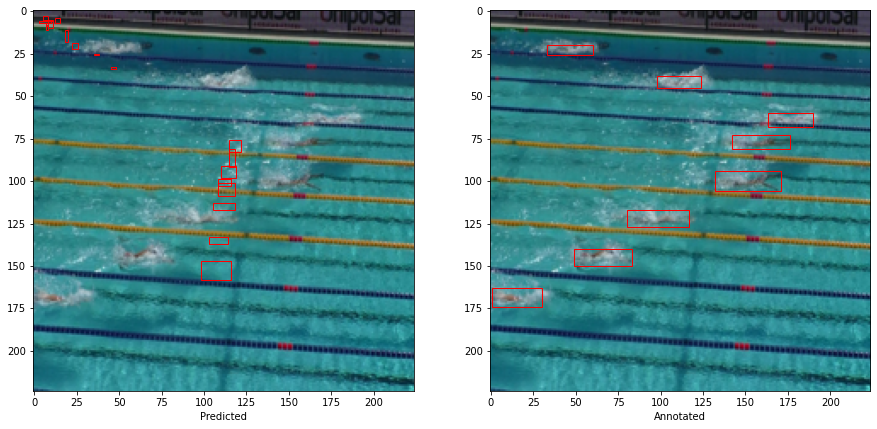

In [12]:
# compare results for 5 images in the test set
compare_images(model, x_test[:5], y_test[:5])

## Second model with annotations ordered by bottom_right_y descending

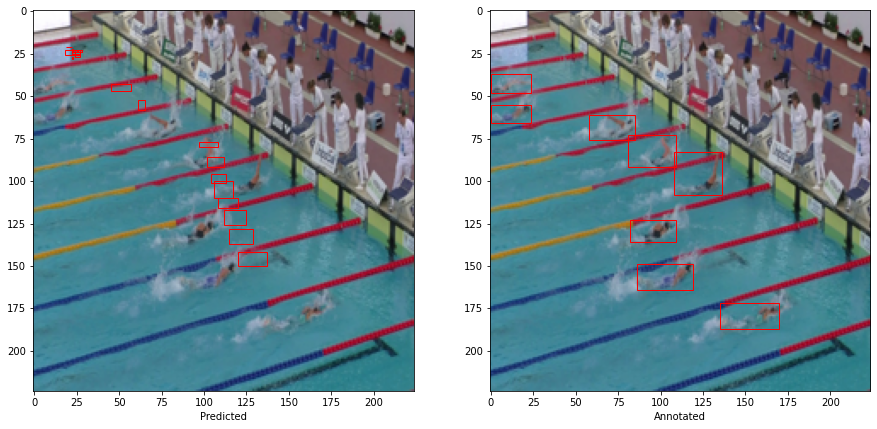

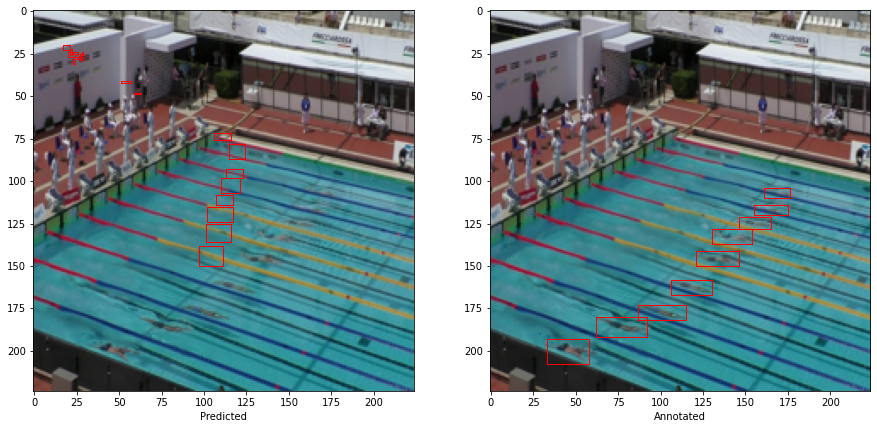

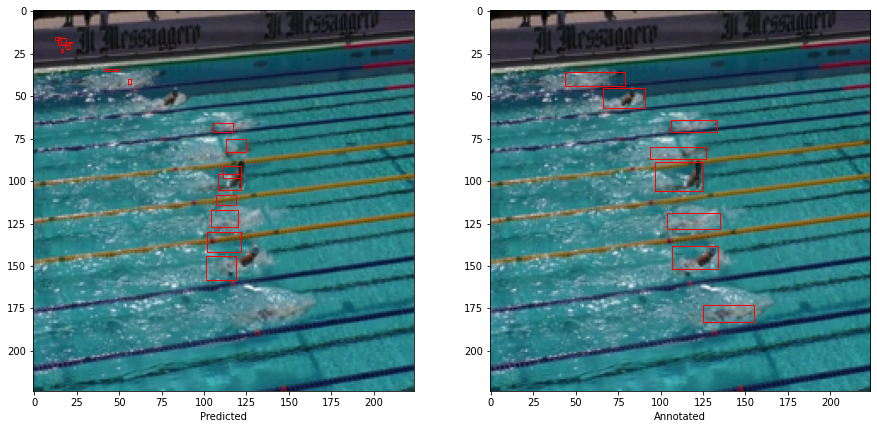

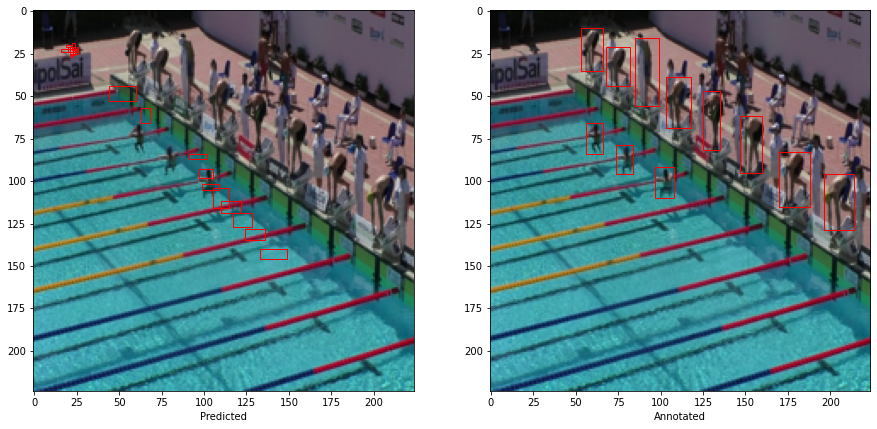

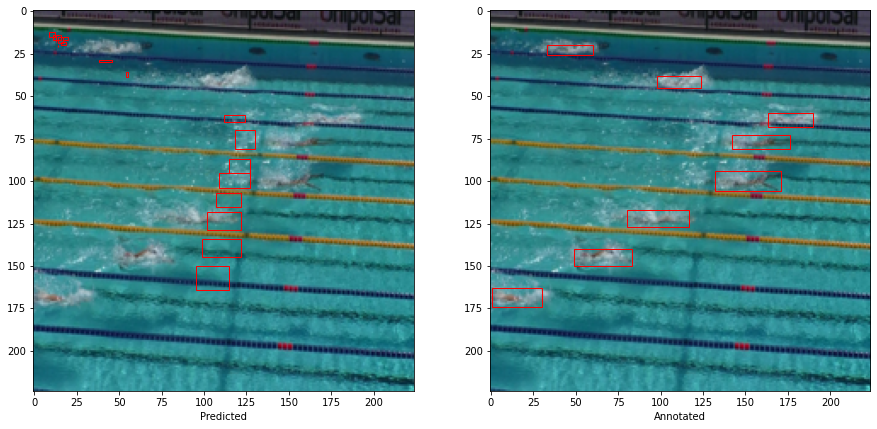

In [9]:
# compare results for 5 images in the test set
compare_images(model, x_test[:5], y_test[:5])

## Third model with lower learning rate and more epochs

In [33]:
model = tf.keras.models.Sequential([
    #create the base layers
    layers.Input((image_size, image_size, 3)),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.Dropout(0.35),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.Dropout(0.35),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.Dropout(0.35),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.35),
    #create the localiser branch
    layers.Dense(neurons * 4, activation="relu"),
    layers.Dropout(0.35),
    layers.Dense(neurons * 2, activation="relu"),
    layers.Dropout(0.35),
    layers.Dense(neurons, activation="relu"),
    layers.Dropout(0.35),
    layers.Dense(max_swimmers * 4, activation="sigmoid")
])

model.compile(optimizer=tf.keras.optimizers.Adam(2e-4), loss="MSE", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 dropout (Dropout)           (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 dropout_1 (Dropout)         (None, 112, 112, 32)      0         
                                                        

In [34]:
history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=200, batch_size=4, callbacks=[checkpoint], verbose=0)
tf.keras.backend.clear_session()


Epoch 1: val_accuracy did not improve from 0.68750

Epoch 2: val_accuracy did not improve from 0.68750

Epoch 3: val_accuracy did not improve from 0.68750

Epoch 4: val_accuracy did not improve from 0.68750

Epoch 5: val_accuracy did not improve from 0.68750

Epoch 6: val_accuracy did not improve from 0.68750

Epoch 7: val_accuracy did not improve from 0.68750

Epoch 8: val_accuracy did not improve from 0.68750

Epoch 9: val_accuracy did not improve from 0.68750

Epoch 10: val_accuracy did not improve from 0.68750

Epoch 11: val_accuracy did not improve from 0.68750

Epoch 12: val_accuracy did not improve from 0.68750

Epoch 13: val_accuracy did not improve from 0.68750

Epoch 14: val_accuracy did not improve from 0.68750

Epoch 15: val_accuracy did not improve from 0.68750

Epoch 16: val_accuracy did not improve from 0.68750

Epoch 17: val_accuracy did not improve from 0.68750

Epoch 18: val_accuracy improved from 0.68750 to 0.70000, saving model to ./models\swimm400_18-0.7000.hdf5




Epoch 154: val_accuracy did not improve from 0.70000

Epoch 155: val_accuracy did not improve from 0.70000

Epoch 156: val_accuracy did not improve from 0.70000

Epoch 157: val_accuracy did not improve from 0.70000

Epoch 158: val_accuracy did not improve from 0.70000

Epoch 159: val_accuracy did not improve from 0.70000

Epoch 160: val_accuracy did not improve from 0.70000

Epoch 161: val_accuracy did not improve from 0.70000

Epoch 162: val_accuracy did not improve from 0.70000

Epoch 163: val_accuracy did not improve from 0.70000

Epoch 164: val_accuracy did not improve from 0.70000

Epoch 165: val_accuracy did not improve from 0.70000

Epoch 166: val_accuracy did not improve from 0.70000

Epoch 167: val_accuracy did not improve from 0.70000

Epoch 168: val_accuracy did not improve from 0.70000

Epoch 169: val_accuracy did not improve from 0.70000

Epoch 170: val_accuracy did not improve from 0.70000

Epoch 171: val_accuracy did not improve from 0.70000

Epoch 172: val_accuracy did

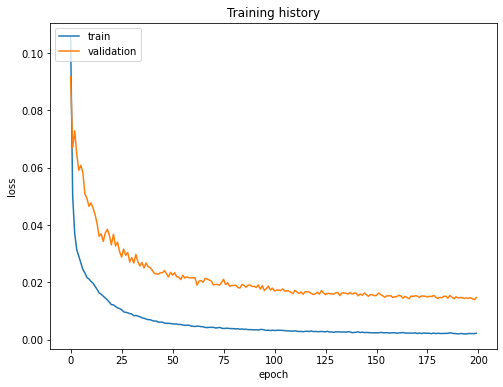

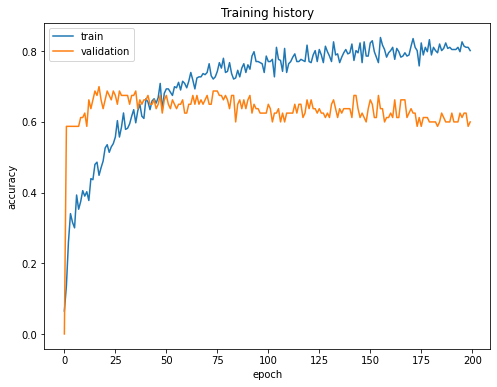

In [35]:
plot_history(history)

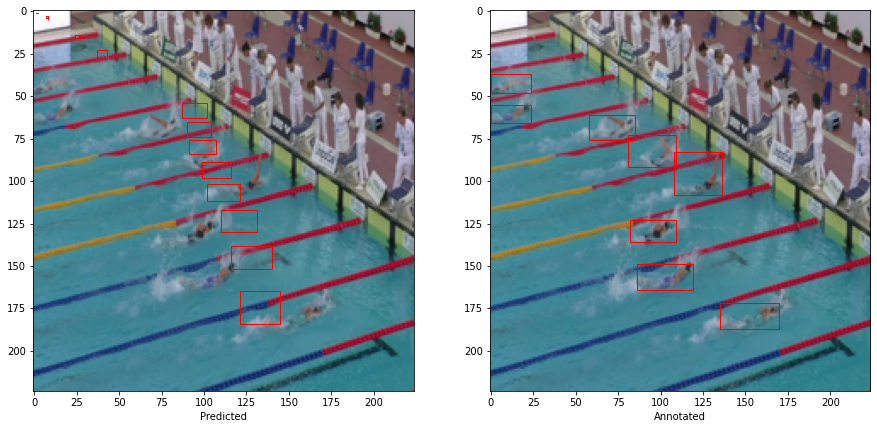

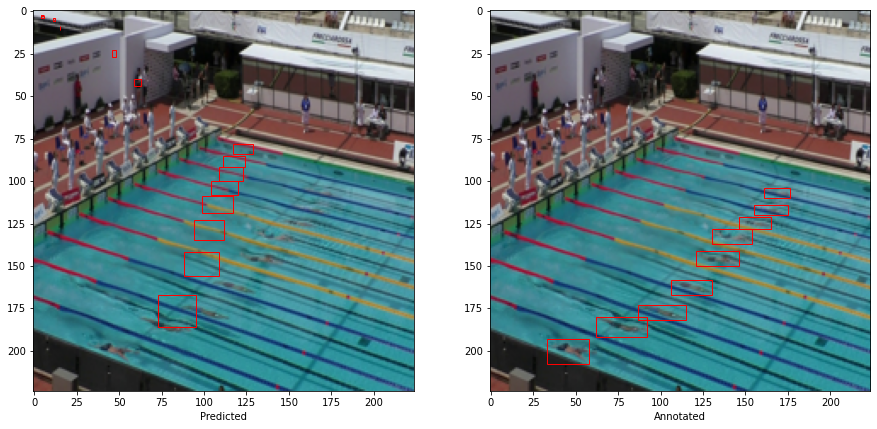

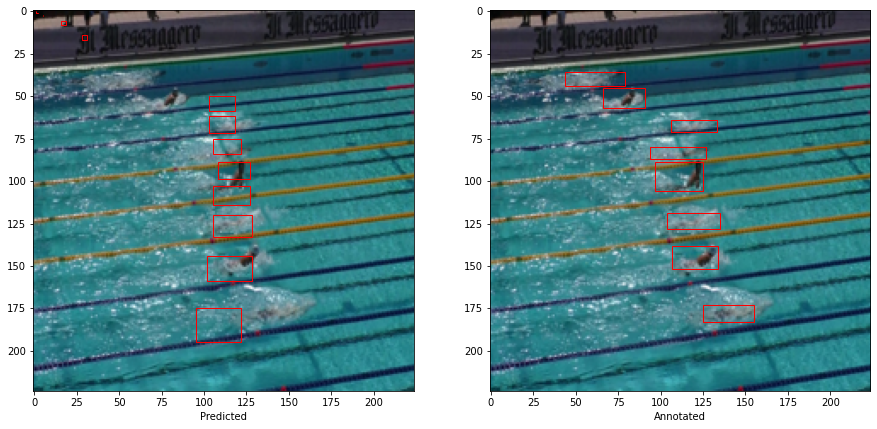

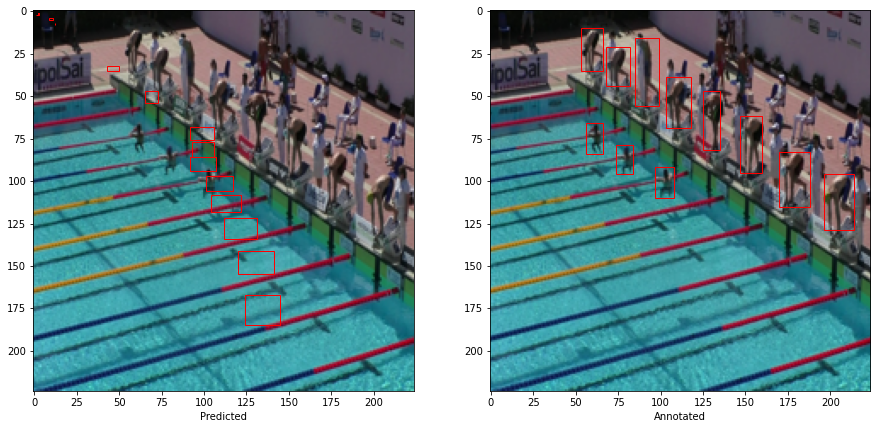

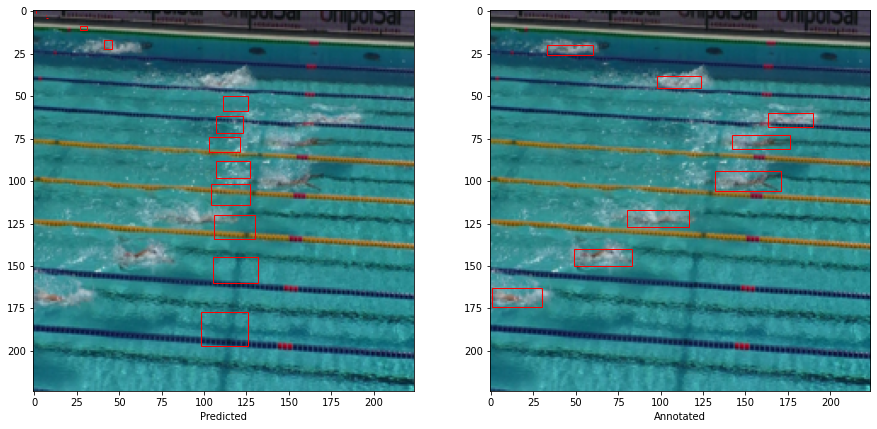

In [36]:
# compare results for 5 images in the test set
compare_images(model, x_test[:5], y_test[:5])

## Discussion

A naive attempt was made to modify the specific example mentioned at the top so that it would be able to detect multiple swimmers. It was believed that if the output layer was a four times multiple of the number of persons instead of just the two coordinates of a single bounding box, that the model would be able to learn to output multiple bounding boxes. If an image contains less than the maximum number of persons, the model should output zero as coordinates so that these results could be detected and removed through postprocessing.

Since the models performance was very poor because of underfitting, another model was trained but the bounding boxes that were used were now sorted in descending order in cell 3 based on the y-coordinate of the bottom right corner of the bounding boxes. This lead to bigger and more consistent bounding boxes that were still grossly misplaced.

An attempt was made to improve the model with a lower learning rate and more epochs which again lead to bigger and more consistent bounding boxes that were still grossly misplaced. This also lead to the less used coordinates, them being for more than eight swimmers, almost exclusively sticking to the top-left corner.

Two different approaches could lead to the desired result
1. An existing multi-instance object detection network such as YOLO could be retrained for this specific usecase (transfer learning)
2. A mechanic could be implemented into the existing network that would identify regions of interest for each swimmer and a bounding box regression model that outputs a single box could be applied to this region

Ultimately, the learned lesson is that object detection is way more difficult than classification.